In [1]:
import pandas as pd #To work with dataframes
import numpy as np #To operate with the data.
import sklearn #To use lineal regresion models.
import operator #To sort a dictionary.
from sklearn.feature_selection import f_regression, mutual_info_regression

In [2]:
import matplotlib.pyplot as plt # para dibujar
%matplotlib inline
from matplotlib import cm
plt.rcParams['figure.figsize'] = (16, 16)
plt.style.use('ggplot')

In [3]:
#Pandas nos mostrará todas los columnas y filas sin sesgar la información.
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [4]:
#Leemos el csv de airbnb y lo convertimos en un dataframe.
df = pd.read_csv("airbnb-listings-extract.csv", sep=";")

Voy a filtrar el campo de "City" por Madrid, ya que no tiene sentido comparar viviendas que sean de distintas ciudades o incluso de distintos países. Ya que el precio de la vivienda varia mucho dependiendo de la ciudad. 

#### Se podría filtrar por país directamente o por cualquier otra ciudad.

In [5]:
# Me quedo unicamente con las viviendas de Madrid.
df = df[df["City"] == "Madrid"]

In [6]:
#Cambio el nombre de las columnas sustituyendo los espacios en blanco por barras bajas para poder trabajar mejor
# a posteriori con el dataframe
new_columns = [str(column).replace(" ","_") for column in df.columns]
df.columns = new_columns

Separo el dataset en dos para tener un dataset de train y otro de test.

In [7]:
#Calculo el número de filas que tengo en mi dataframe
ind = df.index
nrows = len(ind)

In [8]:
# Calculo el número de filas que voy a meter en el train y el número que voy a meter en test
nrows_train = int(round(nrows*0.75,0))
nrows_test = int(nrows_train + 1)

In [9]:
# Creo un dataframe para train y otro para test.
df_train = df.iloc[:nrows_train, :]
df_test = df.iloc[:nrows_test, :]

A partir de aquí voy a trabajar en la limpieza del dataframe de train.

In [10]:
#Vemos que no todos los datos son de tipo int o float. Por ende, tenemos que ver que campos podemos utilizar para crear el modelo lineal.
df_type = df_train.dtypes.apply(lambda x: x.name).to_dict()

In [11]:
# Obetenemos información del dataframe.
# En la columna count, ya se aprecia que hay columnas que tienen valores nulos, los cuales tenemos que eliminar para dejar 
# el dataset lo más limpio posible.
df_info = df_train.describe().T

In [12]:
#Saco el número de filas utilizando el campo del ID. Se supone que el id es un campo donde no puede haber valores repetidos.
#Se podría calcular lo mismo creando un índice y haciendo un len(df_index).
max_value = df_info["count"]
max_value = max_value.max()

In [13]:
#Añado un campo nuevo al df_info. En este campo, indico cuantos valores nulos tiene cada campo.
df_info["null_values"] = max_value - df_info["count"]
df_info["null_values_percent"] = round((df_info["null_values"]/max_value)*100,2)

In [14]:
#Ordeno el df_info por la columna de "null_values"
df_info.sort_values(by=['null_values'], ascending=False)

,count,mean,std,min,25%,50%,75%,max,null_values,null_values_percent
Square_Feet,387.0,3.792274e+02,5.651328e+02,0.000000e+00,0.000000e+00,9.000000e+01,6.460000e+02,5.167000e+03,9518.0,96.09
Monthly_Price,2484.0,1.348033e+03,8.982154e+02,2.500000e+02,7.000000e+02,1.200000e+03,1.682500e+03,8.820000e+03,7421.0,74.92
Weekly_Price,2523.0,3.723222e+02,1.913675e+02,7.000000e+01,2.100000e+02,3.500000e+02,4.950000e+02,9.990000e+02,7382.0,74.53
Security_Deposit,4261.0,1.840127e+02,1.094031e+02,7.000000e+01,1.000000e+02,1.500000e+02,2.000000e+02,9.900000e+02,5644.0,56.98
Cleaning_Fee,5963.0,2.969227e+01,2.631277e+01,4.000000e+00,1.500000e+01,2.500000e+01,3.500000e+01,5.000000e+02,3942.0,39.80
Review_Scores_Location,7745.0,9.556875e+00,7.554209e-01,2.000000e+00,9.000000e+00,1.000000e+01,1.000000e+01,1.000000e+01,2160.0,21.81
Review_Scores_Value,7747.0,9.209759e+00,9.470995e-01,2.000000e+00,9.000000e+00,9.000000e+00,1.000000e+01,1.000000e+01,2158.0,21.79
Review_Scores_Checkin,7748.0,9.621967e+00,7.849874e-01,2.000000e+00,9.000000e+00,1.000000e+01,1.000000e+01,1.000000e+01,2157.0,21.78
Review_Scores_Accuracy,7752.0,9.414861e+00,9.039691e-01,2.000000e+00,9.000000e+00,1.000000e+01,1.000000e+01,1.000000e+01,2153.0,21.74
Review_Scores_Cleanliness,7758.0,9.320057e+00,9.820025e-01,2.000000e+00,9.000000e+00,1.000000e+01,1.000000e+01,1.000000e+01,2147.0,21.68


In [15]:
# Aquí compruebo cuales son las columnas que tienen más de un 25% de valores nulos.
# Al tener tantos valores nulos, voy a eliminarlas directamente.
df_filter = df_info[df_info["null_values_percent"] >= 25]
df_filter

,count,mean,std,min,25%,50%,75%,max,null_values,null_values_percent
Square_Feet,387.0,379.227390,565.132797,0.0,0.0,90.0,646.0,5167.0,9518.0,96.09
Weekly_Price,2523.0,372.322235,191.367528,70.0,210.0,350.0,495.0,999.0,7382.0,74.53
Monthly_Price,2484.0,1348.033011,898.215385,250.0,700.0,1200.0,1682.5,8820.0,7421.0,74.92
Security_Deposit,4261.0,184.012673,109.403145,70.0,100.0,150.0,200.0,990.0,5644.0,56.98
Cleaning_Fee,5963.0,29.692269,26.312766,4.0,15.0,25.0,35.0,500.0,3942.0,39.80


In [16]:
#Elimino las columnas que tienen más de un 25% o más de valores nulos.
columns = ["Square_Feet","Weekly_Price","Monthly_Price","Security_Deposit","Cleaning_Fee"]
df_train.drop(columns = columns)


,ID,Listing_Url,Scrape_ID,Last_Scraped,Name,Summary,Space,Description,Experiences_Offered,Neighborhood_Overview,Notes,Transit,Access,Interaction,House_Rules,Thumbnail_Url,Medium_Url,Picture_Url,XL_Picture_Url,Host_ID,Host_URL,Host_Name,Host_Since,Host_Location,Host_About,Host_Response_Time,Host_Response_Rate,Host_Acceptance_Rate,Host_Thumbnail_Url,Host_Picture_Url,Host_Neighbourhood,Host_Listings_Count,Host_Total_Listings_Count,Host_Verifications,Street,Neighbourhood,Neighbourhood_Cleansed,Neighbourhood_Group_Cleansed,City,State,Zipcode,Market,Smart_Location,Country_Code,Country,Latitude,Longitude,Property_Type,Room_Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed_Type,Amenities,Price,Guests_Included,Extra_People,Minimum_Nights,Maximum_Nights,Calendar_Updated,Has_Availability,Availability_30,Availability_60,Availability_90,Availability_365,Calendar_last_Scraped,Number_of_Reviews,First_Review,Last_Review,Review_Scores_Rating,Review_Scores_Accuracy,Review_Scores_Cleanliness,Review_Scores_Checkin,Review_Scores_Communication,Review_Scores_Location,Review_Scores_Value,License,Jurisdiction_Names,Cancellation_Policy,Calculated_host_listings_count,Reviews_per_Month,Geolocation,Features
40,6478626,https://www.airbnb.com/rooms/6478626,20170407214119,2017-04-08,Habitación con baño .,"Habitación con cama de 150 , para una o dos p...",Tranquilidad y respeto del espacio room with b...,"Habitación con cama de 150 , para una o dos p...",none,"Barrio muy bien comunicado , metro , autobús ,...",NaN,Metro conde de Casal abajo de casa . Líneas de...,"Pueden usar la nevera , microondas , wifi .",Cualquier cosa Q necesiten estaremos para ayud...,Si son fumadores podéis fumar en un patio Q h...,https://a0.muscache.com/im/pictures/86864154/1...,https://a0.muscache.com/im/pictures/86864154/1...,https://public.opendatasoft.com/api/v2/catalog...,https://a0.muscache.com/im/pictures/86864154/1...,25709853,https://www.airbnb.com/users/show/25709853,Vílma,2015-01-06,"Madrid, Community of Madrid, Spain",NaN,within an hour,84.0,NaN,https://a0.muscache.com/im/users/25709853/prof...,https://a0.muscache.com/im/users/25709853/prof...,NaN,3.0,3.0,"email,phone,reviews","Madrid, Comunidad de Madrid 28007, Spain",NaN,Niño Jesús,Retiro,Madrid,Comunidad de Madrid,28007,Madrid,"Madrid, Spain",ES,Spain,40.406953,-3.670894,Apartment,Private room,2,2.0,1.0,1.0,Real Bed,"TV,Wireless Internet,Kitchen,Heating,Essential...",28.0,1,5,1,1125,2 weeks ago,NaN,0,3,12,240,2017-04-07,171,2015-06-14,2017-03-22,87.0,9.0,9.0,9.0,9.0,9.0,9.0,NaN,NaN,flexible,3.0,7.71,"40.4069528479,-3.6708944906","Host Has Profile Pic,Requires License,Instant ..."
41,4941335,https://www.airbnb.com/rooms/4941335,20170407214119,2017-04-08,Cómodo estudio en la calle Goya,Bonito estudio en el barrio comercial y financ...,"Este estudio, regentado por Marta y Marcos, ha...",Bonito estudio en el barrio comercial y financ...,none,NaN,NaN,NaN,En dos agradables sillones puedes tomar un caf...,Te atenderemos en todo lo que necesites. Marta...,No se permite fumar. El estudio está acondicio...,https://a0.muscache.com/im/pictures/69897767/2...,https://a0.muscache.com/im/pictures/69897767/2...,https://public.opendatasoft.com/api/v2/catalog...,https://a0.muscache.com/im/pictures/69897767/2...,25465787,https://www.airbnb.com/users/show/25465787,Marta,2015-01-01,"Madrid, Community of Madrid, Spain",NaN,within a few hours,100.0,NaN,https://a0.muscache.com/im/users/25465787/prof...,https://a0.muscache.com/im/users/25465787/prof...,Recoletos,1.0,1.0,"email,phone,reviews","Recoletos, Madrid, Comunidad de Madrid 28001, ...",Recoletos,Recoletos,Salamanca,Madrid,Comunidad de Madrid,28001,Madrid,"Madrid, Spain",ES,Spain,40.425904,-3.681647,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"TV,Internet,Wireless Internet,Air conditioning...",58.0,1,0,2,1125,6 days ago,NaN,4,9,9,15,2017-04-08,52,2015-03-02,2017-02-12,96.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,NaN,moderate,1.0,2.03,"40.4259039216,-3.6816474596","Host Has Profile Pic,Is Locat

Tras hacer un análisis de las columnas que contiene el dataframe, he decidido quedarme únicamente con aquellas que resultan útiles a la hora de crear el modelo. 

También he analizado cuales de ellas se pueden codificar y cuales no.

Ahora me quedaré con las columnas más relevantes.

In [17]:
# Me quedo con las columnas más útiles.
# Por útiles entiendo parámetros que tienen en común todas las viviendas, es decir, número de habitaciones, número de reviews
# código postal. Es decir, datos concretos.

# Elimino todos aquellos datos que son abstractos como fechas, url's, Ids de varios tipos, opiniones, descripciones...

useful_columns =  ["Neighbourhood","Zipcode","Property_Type",
                    "Room_Type", "Accommodates", "Bathrooms", "Bedrooms",
                    "Beds", "Bed_Type", "Price","Number_of_Reviews",
                    "Review_Scores_Value","Cancellation_Policy"]

df_train = df_train[useful_columns]

In [18]:
#Analizo los valores de Zipcode, ya que he visto que hay varios que vienen por defecto con errores.

# Por ello, mediante un replace, solvento todos los errores que he visto al hacer un df_train["Zipcode"].unique()
df_train["Zipcode"].replace({"28002\n28002": "28002",
                             "Madrid 28004": "28004",
                             "2805":"28005",
                             "2015":"28015",
                             "2815":"28015"}, inplace=True)   

In [19]:
# Elimino los valores nulos del dataframe:

# Esto lo hago sobre todo para que me deje convertir el campo de Zipcode a un campo de tipo int64.

# De esta forma puedo incluirlo en la matriz de correlación.
df_train= df_train[df_train['Neighbourhood'].notna()]
df_train= df_train[df_train['Zipcode'].notna()]
df_train= df_train[df_train['Bathrooms'].notna()]
df_train= df_train[df_train['Review_Scores_Value'].notna()]
df_train= df_train[df_train['Price'].notna()]
df_train= df_train[df_train['Bedrooms'].notna()]

In [20]:
df_train.isnull().sum(axis = 0)

Neighbourhood          0
Zipcode                0
Property_Type          0
Room_Type              0
Accommodates           0
Bathrooms              0
Bedrooms               0
Beds                   2
Bed_Type               0
Price                  0
Number_of_Reviews      0
Review_Scores_Value    0
Cancellation_Policy    0
dtype: int64

In [21]:
#Convierto el campo "Zipcode" en un campo de tipo numérico para incluirlo en la matriz de correlación.
df_train["Zipcode"] = df_train["Zipcode"].apply(pd.to_numeric, errors='coerce')

A continuación, voy a codificar campos de tipo de tipos String u Object como por ejemplo: Neighbourhood, Property_Type,
Bed_Type y Cancellation_Policy.


Para ello, voy a asignar un valor a cada tipo de valor que tiene cada campo distinto.

In [22]:
# Comenzamos codificando Neigbourdhood

neighbourdhoods = df_train["Neighbourhood"].unique()

dictionary_neigbourdhoods = {}
counter = 0

for neigbourhood in neighbourdhoods:
    if neigbourhood not in dictionary_neigbourdhoods.keys():
        dictionary_neigbourdhoods[neigbourhood] = counter
        counter =+ counter +1

df_Neighbourhood = pd.DataFrame({'Neighbourhood': list(dictionary_neigbourdhoods.keys()),
                                 'Neighbourhood_Code': list(dictionary_neigbourdhoods.values()) 
                                })

df_train = pd.merge(df_train, df_Neighbourhood, on='Neighbourhood')

df_train = df_train[['Neighbourhood',  'Neighbourhood_Code', 'Zipcode', 'Property_Type', 'Room_Type',
                     'Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Bed_Type', 'Price',
                     'Number_of_Reviews', 'Review_Scores_Value', 'Cancellation_Policy']]

In [23]:
# Codificamos el campo de Property Type:

properties = df_train["Property_Type"].unique()

dictionary_properties = {}
counter = 0

for property in properties:
    if property not in dictionary_properties.keys():
        dictionary_properties[property] = counter
        counter =+ counter +1

df_property = pd.DataFrame({'Property_Type': list(dictionary_properties.keys()),
                                 'Property_Type_Code': list(dictionary_properties.values()) 
                                })

df_train = pd.merge(df_train, df_property, on='Property_Type')

df_train = df_train[['Neighbourhood',  'Neighbourhood_Code', 'Zipcode', 'Property_Type', 'Property_Type_Code', 'Room_Type', 
                     'Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Bed_Type', 'Price',
                     'Number_of_Reviews', 'Review_Scores_Value', 'Cancellation_Policy']]

In [24]:
# Codificamos el campo de Room_Type:

rooms_types = df_train["Room_Type"].unique()

dictionary_room_type = {}
counter = 0

for room in rooms_types:
    if room not in dictionary_room_type.keys():
        dictionary_room_type[room] = counter
        counter =+ counter +1

df_room = pd.DataFrame({'Room_Type': list(dictionary_room_type.keys()),
                                 'Room_Type_Code': list(dictionary_room_type.values()) 
                                })

df_train = pd.merge(df_train, df_room, on='Room_Type')

df_train = df_train[['Neighbourhood',  'Neighbourhood_Code', 'Zipcode', 'Property_Type','Property_Type', 'Property_Type_Code',
                     'Room_Type','Room_Type_Code','Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Bed_Type', 'Price',
                     'Number_of_Reviews', 'Review_Scores_Value', 'Cancellation_Policy']]

In [25]:
# Codificamos el campo de Bed Type:

bed_types = df_train["Bed_Type"].unique()

dictionary_bed_types = {}
counter = 0

for bed in bed_types:
    if bed not in dictionary_properties.keys():
        dictionary_bed_types[bed] = counter
        counter =+ counter +1

df_bed_type = pd.DataFrame({'Bed_Type': list(dictionary_bed_types.keys()),
                                 'Bed_Type_Code': list(dictionary_bed_types.values()) 
                                })

df_train = pd.merge(df_train, df_bed_type, on='Bed_Type')

df_train = df_train[['Neighbourhood',  'Neighbourhood_Code', 'Zipcode', 'Property_Type', 'Property_Type_Code', 'Room_Type',
                     'Room_Type_Code', 'Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Bed_Type', 'Bed_Type_Code', 'Price',
                     'Number_of_Reviews', 'Review_Scores_Value', 'Cancellation_Policy']]

In [26]:
# Codificamos el campo de Cancellation Policy:

cancellations_policies = df_train["Cancellation_Policy"].unique()

dictionary_cancellations = {}
counter = 0

for cancellation in cancellations_policies:
    if bed not in dictionary_cancellations.keys():
        dictionary_cancellations[cancellation] = counter
        counter =+ counter +1

df_cancellations = pd.DataFrame({'Cancellation_Policy': list(dictionary_cancellations.keys()),
                                 'Cancellation_Policy_Code': list(dictionary_cancellations.values()) 
                                })

df_train = pd.merge(df_train, df_cancellations, on='Cancellation_Policy')

df_train = df_train[['Neighbourhood',  'Neighbourhood_Code', 'Zipcode', 'Property_Type', 'Property_Type_Code', 'Room_Type',
                     'Room_Type_Code', 'Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Bed_Type', 'Bed_Type_Code', 'Price',
                     'Number_of_Reviews', 'Review_Scores_Value', 'Cancellation_Policy','Cancellation_Policy_Code']]

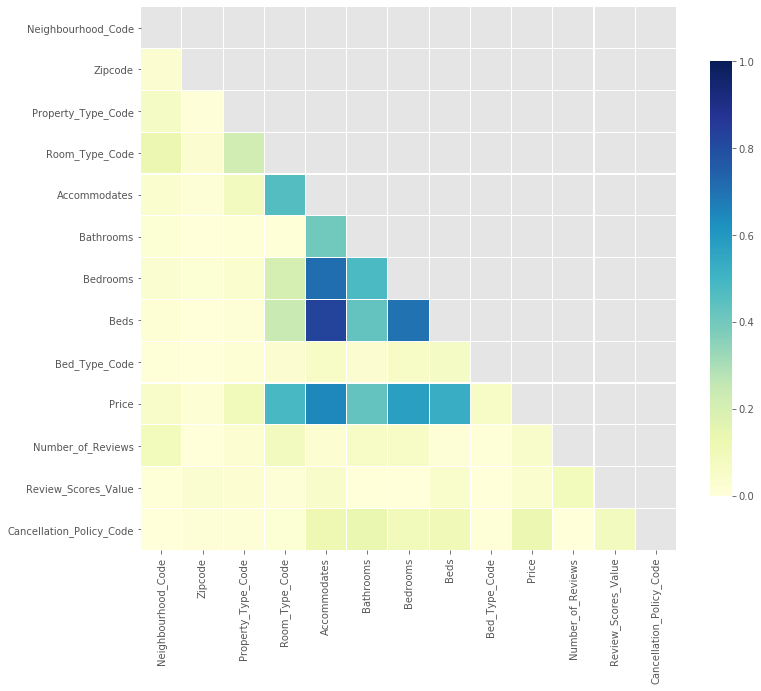

In [27]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(df_train.corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

Por lo que vemos en la matriz de correlación, el precio de una vivienda depende principalmente del número de personas, el número de baños, el número de habitaciones y el número de camas de la vivienda.

In [28]:
df_train.corr() # matriz de correlación

,Neighbourhood_Code,Zipcode,Property_Type_Code,Room_Type_Code,Accommodates,Bathrooms,Bedrooms,Beds,Bed_Type_Code,Price,Number_of_Reviews,Review_Scores_Value,Cancellation_Policy_Code
Neighbourhood_Code,1.000000,-0.029264,-0.068134,-0.129760,0.038490,-0.020710,-0.031393,-0.018446,0.009524,0.052960,0.091202,0.008973,0.003570
Zipcode,-0.029264,1.000000,-0.005433,0.029289,-0.013997,0.003564,0.020474,-0.002219,0.001042,-0.016275,-0.002292,0.033077,0.012659
Property_Type_Code,-0.068134,-0.005433,1.000000,0.215382,-0.084633,0.008122,-0.037209,-0.013949,0.015919,-0.095858,-0.027179,0.024126,-0.013088
Room_Type_Code,-0.129760,0.029289,0.215382,1.000000,-0.462103,0.011477,-0.205849,-0.239735,0.030894,-0.485334,-0.082070,0.013700,-0.021073
Accommodates,0.038490,-0.013997,-0.084633,-0.462103,1.000000,0.405536,0.707418,0.825908,-0.059722,0.647238,0.024413,-0.050254,0.119739
Bathrooms,-0.020710,0.003564,0.008122,0.011477,0.405536,1.000000,0.479336,0.426785,-0.031112,0.426481,-0.057855,-0.002606,0.136737
Bedrooms,-0.031393,0.020474,-0.037209,-0.205849,0.707418,0.479336,1.000000,0.702856,-0.059846,0.576413,-0.057257,0.002426,0.099556
Beds,-0.018446,-0.002219,-0.013949,-0.239735,0.825908,0.426785,0.702856,1.000000,-0.067091,0.528047,-0.013151,-0.044315,0.107648
Bed_Type_Code,0.009524,0.001042,0.015919,0.030894,-0.059722,-0.031112,-0.059846,-0.067091,1.000000,-0.056297,-0.010250,-0.001782,-0.009153
Price,0.052960,-0.016275,-0.095858,-0.485334,0.647238,0.426481,0.576413,0.528047,-0.056297,1.000000,-0.049376,0.036772,0.130447


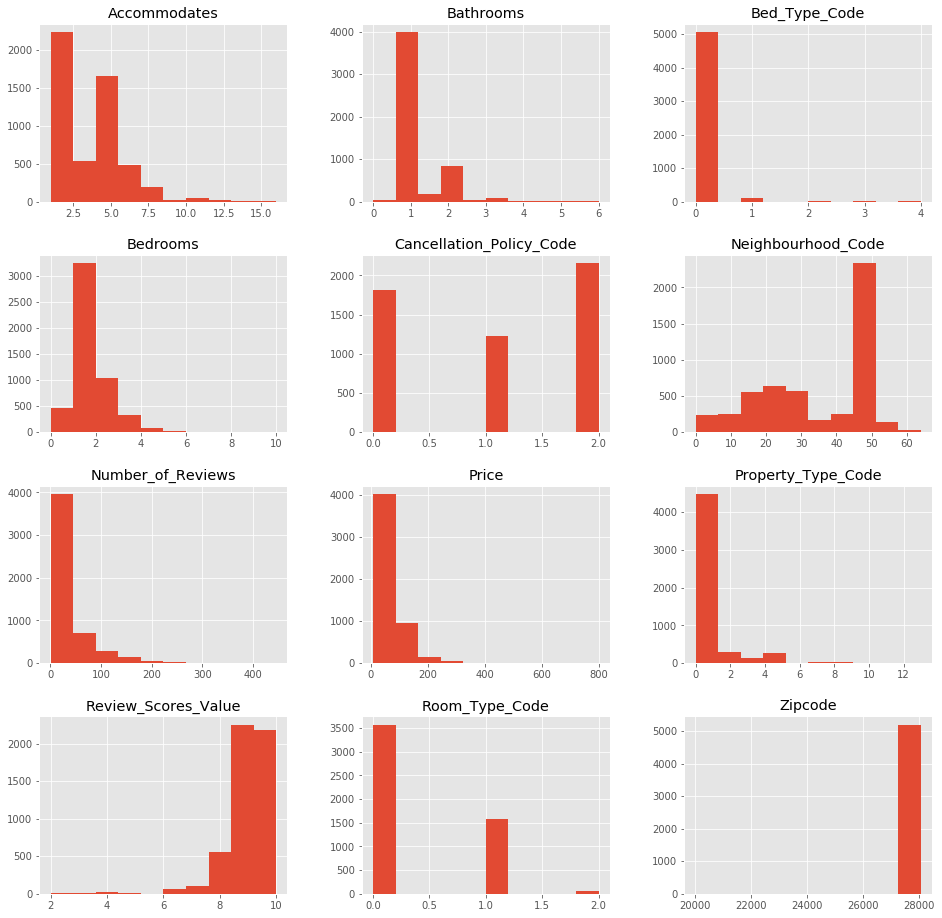

In [41]:
df_train.hist()
plt.show()

In [37]:
dictionary_room_type

{'Entire home/apt': 0, 'Private room': 1, 'Shared room': 2}

Vamos a comentar las gráficas anteiores:
    
    1. Vemos que la mayoría de viviendas aceptan entre 1 y 5 personas.
    2. La mayoría de viviendas cuentan con un baño y unas pocas con 2 baños.
    3. Respecto al "Bed_Type" vemos que casi todas tienen "Real Bed", que equivale al número 0 en el Bed_Type_Code.
    4. Vemos que la mayoría de viviendas tiene entre 1 y 3 habitaciones. La mayoría cuenta solo con una.
    5. Respecto al número de camas, vemos que la mauoría de casas tiene solo 1 cama, pero también hay agunas viviendas que            cuentan hasta con 5 camas.
    6. Respecto a la política de cancelación, vemos que está muy repartido entre {'moderate':0,'flexible': 1,'strict':2}.
    7. Respecto a lo barrios que cuentan con mayor número de viviendas. Estas son:            
            {Malasaña:582, Embajadores:554,La Latina:505, Sol:434, Cortes:361}
    8. Respecto al número de reviews, vemos que lamayoría de viviendas tienen entre 0 y 150 reviews.
    9. Respecto al precio, vemos que la mayoría de viviendas oslizan entre 0 y 200€.
    10. Respecto a Property Type Code, vemos que la mayoría son {'Apartment': 0}.
    11. Respecto a los score values, vemos que la inmensa mayoría de viviendas, tienen score values muy altas.
    12. Respecto a los Room Type, vemos que la inmensa mayoría de viviendas que se ofertan son de tipo "Entire home/apt".
        {'Entire home/apt': 0, 'Private room': 1, 'Shared room': 2}

In [32]:
# Me quedo únicamente con los campos numéricos y los campos codificados.
df_train = df_train[['Price','Neighbourhood_Code', 'Zipcode','Property_Type_Code', 
                     'Room_Type_Code','Accommodates', 'Bathrooms', 'Bedrooms', 'Bed_Type_Code', 
                     'Number_of_Reviews', 'Review_Scores_Value', 'Cancellation_Policy_Code']]

In [42]:
# Convierto todos los campos a dtype = int64 . Esto lo hago porque pueden saltar errores al ser datos numéricos muy largos de tipo "float".
df_train = df_train.apply(pd.to_numeric, errors='coerce')

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


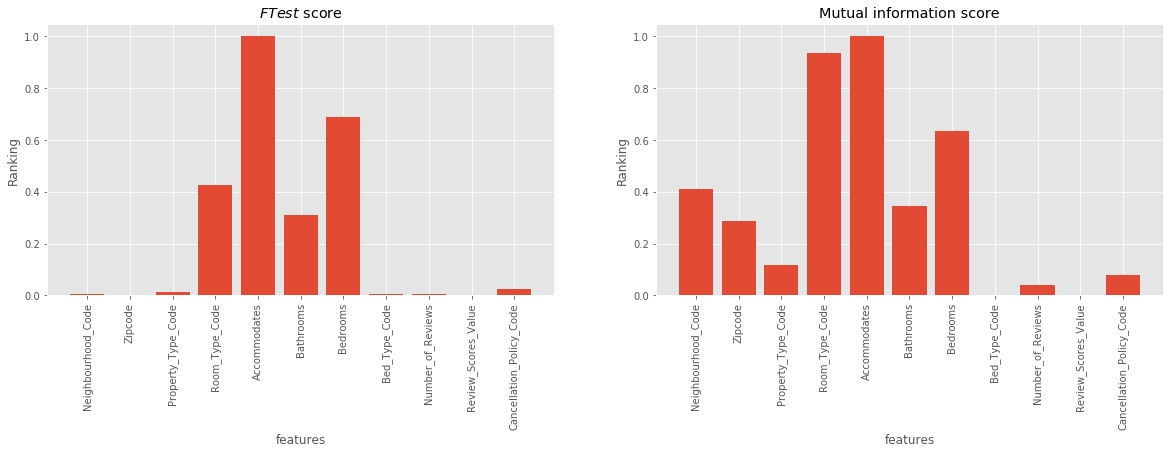

In [34]:
# convertimos el DataFrame al formato necesario para scikit-learn
data = df_train.values 

y = data[:,0:1]     # nos quedamos con la 1ª columna, price
X = data[:,1:]      # nos quedamos con el resto

feature_names = df_train.columns[1:]


# do calculations
f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

# do some plotting
plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
plt.bar(range(X.shape[1]),f_test,  align="center")
plt.xticks(range(X.shape[1]),feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('$FTest$ score')

plt.subplot(1,2,2)
plt.bar(range(X.shape[1]),mi, align="center")
plt.xticks(range(X.shape[1]),feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Mutual information score')

plt.show()